In [1]:
import numpy as np
import sobol_seq
import vorostereology as vs
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d as m3
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import PolyCollection
from scipy.spatial import Voronoi, voronoi_plot_2d
import voroplusplus as vpp
import pyvoro
from scipy import ndimage
import pandas as pd
import csv
from pointpats import PoissonPointProcess, PoissonClusterPointProcess, Window, poly_from_bbox, PointPattern

Text(0.5, 0, 'z')

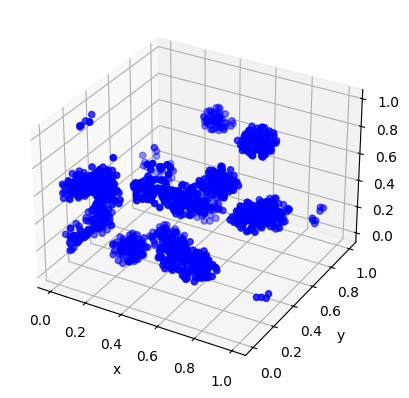

In [2]:
# ######################################## Define/ initialize points##############################################
xMin = 0;
xMax = 1;
yMin = 0;
yMax = 1;
zMin = 0;
zMax = 1;

domain = [[xMin, xMax], [yMin, yMax], [zMin, zMax]]

# Parameters for the parent and daughter point processes
lambdaParent = 10;  # density of parent Poisson point process
lambdaDaughter = 100;  # mean number of points in each cluster
radiusCluster = 0.1;  # radius of cluster disk (for daughter points)

# Extended simulation windows parameters
rExt = radiusCluster;  # extension parameter -- use cluster radius
xMinExt = xMin - rExt;
xMaxExt = xMax + rExt;
yMinExt = yMin - rExt;
yMaxExt = yMax + rExt;
zMinExt = zMin - rExt;
zMaxExt = zMax + rExt;
# rectangle dimensions
xDeltaExt = xMaxExt - xMinExt;
yDeltaExt = yMaxExt - yMinExt;
zDeltaExt = zMaxExt - zMinExt;
volumeTotalExt = xDeltaExt * yDeltaExt*zDeltaExt;  # volume of extended rectangle

# Simulate Poisson point process for the parents
numbPointsParent = np.random.poisson(volumeTotalExt * lambdaParent);  # Poisson number of points
# x and y coordinates of Poisson points for the parent
xxParent = xMinExt + xDeltaExt * np.random.uniform(0, 1, numbPointsParent);
yyParent = yMinExt + yDeltaExt * np.random.uniform(0, 1, numbPointsParent);
zzParent = zMinExt + zDeltaExt * np.random.uniform(0, 1, numbPointsParent);
# Simulate Poisson point process for the daughters (ie final poiint process)
numbPointsDaughter = np.random.poisson(lambdaDaughter, numbPointsParent);
numbPoints = sum(numbPointsDaughter);  # total number of points

# Generate the (relative) locations in polar coordinates by
# simulating independent variables.
theta = 2 * np.pi * np.random.uniform(0, 1, numbPoints);  # angular coordinates
rho = radiusCluster * np.sqrt(np.random.uniform(0, 1, numbPoints));  # radial coordinates
V=2 * np.random.uniform(0, 1, numbPoints)-1;

# Convert from polar to Cartesian coordinates
xx0 = rho * np.cos(theta)* np.sqrt(1-V**2);
yy0 = rho * np.sin(theta)* np.sqrt(1-V**2);
zz0 = rho * V
# replicate parent points (ie centres of disks/clusters)
xx = np.repeat(xxParent, numbPointsDaughter);
yy = np.repeat(yyParent, numbPointsDaughter);
zz = np.repeat(zzParent, numbPointsDaughter);
# translate points (ie parents points are the centres of cluster disks)
xx = xx + xx0;
yy = yy + yy0;
zz = zz + zz0;
# thin points if outside the simulation window
booleInside = ((xx >= xMin) & (xx <= xMax) & (yy >= yMin) & (yy <= yMax)& (zz >= zMin) & (zz <= zMax));
# retain points inside simulation window
xx = xx[booleInside];  
yy = yy[booleInside];
zz = zz[booleInside]
# Plotting
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(xx, yy,zz,color='b');
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

In [3]:
s=np.array([xx.T,yy.T,zz.T])
s.T

array([[8.02777679e-01, 8.91342077e-02, 2.64024892e-01],
       [7.26559346e-01, 1.10822405e-01, 3.11704448e-01],
       [6.97592967e-01, 1.62108000e-01, 2.82289496e-01],
       ...,
       [8.02509624e-04, 7.87540295e-01, 3.74691634e-01],
       [1.35985221e-02, 8.82556433e-01, 3.76664422e-01],
       [3.14038746e-02, 8.72366665e-01, 3.64059618e-01]])

In [4]:
#######Generate 3D Voronoi###########
pycells=pyvoro.compute_voronoi(
s.T, # point positions
[[0.0, 1.0], [0.0, 1.0], [0.0, 1.0]], # limits
10.0, # block size
# particle radii -- optional, and keyword-compatible arg.
)

In [5]:
(s.T).shape

(1503, 3)

In [6]:
pycells

[{'original': array([0.80277768, 0.08913421, 0.26402489]),
  'volume': 0.003633451976946569,
  'vertices': [array([0.79129862, 0.10861515, 0.28640553]),
   array([0.88838477, 0.01378992, 0.08796086]),
   array([0.85497269, 0.        , 0.22782939]),
   array([0.79015462, 0.09804109, 0.22277415]),
   array([0.88771267, 0.12501261, 0.16475716]),
   array([1.        , 0.14278161, 0.29538048]),
   array([1.        , 0.0118653 , 0.39288012]),
   array([0.78843402, 0.11037467, 0.28047196]),
   array([1.00000000e+00, 1.38777878e-17, 3.81217204e-01]),
   array([0.79425686, 0.07297532, 0.26486763]),
   array([0.79370081, 0.1078085 , 0.28963738]),
   array([1.        , 0.1302722 , 0.32799648]),
   array([1.00000000e+00, 1.38777878e-17, 1.95885043e-01]),
   array([0.89766819, 0.        , 0.0881272 ]),
   array([0.93620707, 0.15404093, 0.23605091]),
   array([0.80126611, 0.12139445, 0.23007389]),
   array([0.79552209, 0.09426144, 0.2975081 ]),
   array([9.03544187e-01, 1.38777878e-17, 3.01947198e-0

In [7]:
######Taking 9 cross-sections#####
coeffs = np.array([0.5, 0.0, 0.0])
offset = np.array([0.1, 0.5, 1.0])
cross_section_tot= [vs.compute_cross_section(coeffs=coeffs, points = s.T, offset=offset, domain=domain, weights = np.zeros((s.T).shape[0]))]
for x in range(2, 10, 1):
     offset =  np.array([x*0.1, 0.5, 1.0])
     cross_section_tot += [vs.compute_cross_section(coeffs=coeffs, points = s.T, offset=offset, domain=domain, weights = np.zeros((s.T).shape[0]))]


In [27]:
fig = plt.figure()
ax = Axes3D(fig)

for cell_idx, cell in enumerate(pycells):
    for facet_idx, facet in enumerate(cell['faces']):
        idx = np.array(facet['vertices'])
        polygon = m3.art3d.Poly3DCollection([np.array(cell['vertices'])[idx]])
        polygon.set_edgecolor('k')
        polygon.set_alpha(0.1)
        ax.add_collection3d(polygon)


for x in range(0, 9, 1):
    for cell in cross_section_tot[x]['3d']:
        polygon = m3.art3d.Poly3DCollection([cell])
        polygon.set_color("red")
        polygon.set_edgecolor('k')
        ax.add_collection3d(polygon)
    
ax.set_xlim3d(domain[0])
ax.set_ylim3d(domain[1])
ax.set_zlim3d(domain[2])
ax.set_box_aspect((1, 1, 1))
ax.set_axis_off()
plt.show(block=False)



<Figure size 640x480 with 0 Axes>

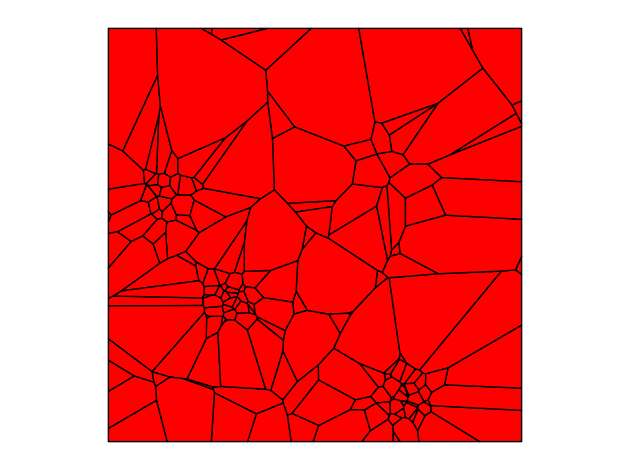

In [8]:
fig2 = plt.figure()
ax2 = fig2.add_subplot(111)

coll = PolyCollection(cross_section_tot[6]['2d'], facecolors="red", edgecolors='k')
ax2.add_collection(coll)
ax2.axis("equal")
ax2.set_axis_off()
fig2.tight_layout()
plt.show()





In [26]:
all_indices = set()
for cross_section in cross_section_tot:
    all_indices.update(cross_section["original_indices"])
index_to_value = {index: np.random.rand() for index in all_indices}
# [index_to_value[index] for index in cross_section_tot[0]["original_indices"]]
index_to_color = {i: (1, 1-x, 1-x) for i, x in zip(all_indices, np.random.uniform(0.2, 1, size=len(all_indices)))}
index_to_color

{0: (1, 0.07238266821150519, 0.07238266821150519),
 1: (1, 0.6468391705440273, 0.6468391705440273),
 2: (1, 0.7330503173717504, 0.7330503173717504),
 4: (1, 0.2753368050990812, 0.2753368050990812),
 5: (1, 0.6916667495872102, 0.6916667495872102),
 6: (1, 0.054146959055659805, 0.054146959055659805),
 8: (1, 0.7356696607333255, 0.7356696607333255),
 10: (1, 0.7727872875884441, 0.7727872875884441),
 13: (1, 0.5751906300141114, 0.5751906300141114),
 14: (1, 0.2788381717349677, 0.2788381717349677),
 15: (1, 0.3969279807836251, 0.3969279807836251),
 16: (1, 0.01042625794965768, 0.01042625794965768),
 19: (1, 0.6531499893812037, 0.6531499893812037),
 20: (1, 0.6132657010056815, 0.6132657010056815),
 23: (1, 0.7134163756853215, 0.7134163756853215),
 27: (1, 0.5387139200216637, 0.5387139200216637),
 28: (1, 0.10242476206075479, 0.10242476206075479),
 29: (1, 0.15037723500678135, 0.15037723500678135),
 32: (1, 0.4054677325263598, 0.4054677325263598),
 33: (1, 0.4455260257139655, 0.44552602571396

In [29]:
len(cross_section_tot[1]["original_indices"]), len(cross_section_tot[1]["2d"])

(171, 171)

In [34]:
#####Taking the centroid of the visible grains in the cross-sections and create data-set#####
x = [p[0] for p in cross_section_tot[0]['2d'][0]]
y = [p[1] for p in cross_section_tot[0]['2d'][0]]
centroid0=[(sum(x) / len(cross_section_tot[0]['2d'][0]), sum(y) / len(cross_section_tot[0]['2d'][0]))]
for i in range(1,len(cross_section_tot[0]['2d'])):
     x = [p[0] for p in cross_section_tot[0]['2d'][i]]
     y = [p[1] for p in cross_section_tot[0]['2d'][i]]
     centroid0.append((sum(x) / len(cross_section_tot[0]['2d'][i]), sum(y) / len(cross_section_tot[0]['2d'][i])))
id_sec=pd.DataFrame([0.1]*len(cross_section_tot[0]['2d']),columns=['id_sec'])
id_grains=pd.DataFrame(cross_section_tot[0]['original_indices'],columns=['id_grain'])
df0=pd.DataFrame(centroid0,columns=['x','y'])
df0=pd.concat([df0.reset_index(drop=True), id_sec, id_grains], axis=1)
# for j in range(1,8):
#     x = [p[0] for p in cross_section_tot[j]['2d'][0]]
#     y = [p[1] for p in cross_section_tot[j]['2d'][0]]
#     centroidj=[(sum(x) / len(cross_section_tot[j]['2d'][0]), sum(y) / len(cross_section_tot[j]['2d'][0]))]
#     for i in range(1,len(cross_section_tot[j]['2d'])):
#         x = [p[0] for p in cross_section_tot[j]['2d'][i]]
#         y = [p[1] for p in cross_section_tot[j]['2d'][i]]   
#         centroidj.append((sum(x) / len(cross_section_tot[j]['2d'][i]), sum(y) / len(cross_section_tot[j]['2d'][i])))
#     id_sec=pd.DataFrame([(j+1)*0.1]*len(cross_section_tot[j]['2d']),columns=['id_sec'])
#     id_grains=pd.DataFrame(cross_section_tot[j]['original_indices'],columns=['id_grain'])
#     dfj=pd.DataFrame(centroidj,columns=['x','y'])
#     dfj=pd.concat([dfj.reset_index(drop=True), id_sec, id_grains], axis=1)
#     dfj_tot=pd.concat([df0,dfj])
#     df0=dfj_tot
# np.array(centroid0)

df0

,x,y,id_sec,id_grain
0,0.858624,-0.374394,0.1,1211
1,0.946929,-0.399789,0.1,1214
2,0.908050,-0.462515,0.1,1221
3,0.882297,-0.389697,0.1,1234
4,0.871690,-0.336877,0.1,1235
...,...,...,...,...
126,0.033448,-0.407285,0.1,107
127,0.141869,-0.422514,0.1,417
128,0.034214,-0.269060,0.1,103
129,0.097868,-0.006454,0.1,105


In [31]:
df0

,x,y,id_sec,id_grain
0,0.858624,-0.374394,0.1,1211
1,0.946929,-0.399789,0.1,1214
2,0.908050,-0.462515,0.1,1221
3,0.882297,-0.389697,0.1,1234
4,0.871690,-0.336877,0.1,1235
...,...,...,...,...
166,0.138983,0.123395,0.8,141
167,0.190846,0.127842,0.8,152
168,0.099533,0.106324,0.8,153
169,0.176386,0.117702,0.8,161


In [ ]:
#####Taking the center of mass of the visible grains in the cross-sections and create data-set#####
center_mass0=[ndimage.measurements.center_of_mass(cross_section_tot[0]['2d'][0])]
for i in range(1,len(cross_section_tot[0]['2d'])):
 center_mass0.append(ndimage.measurements.center_of_mass(cross_section_tot[0]['2d'][i]))

id_sec=pd.DataFrame([0.1]*len(cross_section_tot[0]['2d']),columns=['id_sec'])
id_grains=pd.DataFrame(cross_section_tot[0]['original_indices'],columns=['id_grain'])
df0=pd.DataFrame(center_mass0,columns=['x','y'])
df0=pd.concat([df0.reset_index(drop=True), id_sec, id_grains], axis=1)
for x in range(1,8):
    center_massx=[ndimage.measurements.center_of_mass(cross_section_tot[x]['2d'][0])]
    for i in range(1,len(cross_section_tot[x]['2d'])):
     center_massx.append(ndimage.measurements.center_of_mass(cross_section_tot[x]['2d'][i]))
    id_sec=pd.DataFrame([(x+1)*0.1]*len(cross_section_tot[x]['2d']),columns=['id_sec'])
    id_grains=pd.DataFrame(cross_section_tot[x]['original_indices'],columns=['id_grain'])
    dfx=pd.DataFrame(center_massx,columns=['x','y'])
    dfx=pd.concat([dfx.reset_index(drop=True), id_sec, id_grains], axis=1)
    dfx_tot=pd.concat([df0,dfx])
    df0=dfx_tot   

In [44]:
####Finalize dataset and export data####
id_vor=pd.DataFrame([1]*dfj_tot.shape[0],columns=['id_vor'])
dfj_tot=pd.concat([dfj_tot.reset_index(drop=True), id_vor], axis=1)

In [45]:
dfj_tot.to_csv('dftotcl1.csv')

In [ ]:
#########Generazione multipla######
dfj_tot_tot=pd.DataFrame(columns=['x','y','id_sec','id_grain','id_vor'])
for k in range(1,1000):
    s = np.random.default_rng().uniform(0,1,size=(1000,3))
    pycells=pyvoro.compute_voronoi(
    s, [[0.0, 1.0], [0.0, 1.0], [0.0, 1.0]], 1.0,)
    coeffs = np.array([0.5, 0.0, 0.0])
    cross_section_tot=[vs.compute_cross_section(pycells, coeffs, np.array([0.1, 0.5, 1.0]))]
    for x in range(2, 10, 1):
         cross_section_tot.append(vs.compute_cross_section(pycells, coeffs, np.array([x*0.1, 0.5, 1.0])))
    x = [p[0] for p in cross_section_tot[0]['2d'][0]]
    y = [p[1] for p in cross_section_tot[0]['2d'][0]]
    centroid0=[(sum(x) / len(cross_section_tot[0]['2d'][0]), sum(y) / len(cross_section_tot[0]['2d'][0]))]
    for i in range(1,len(cross_section_tot[0]['2d'])):
         x = [p[0] for p in cross_section_tot[0]['2d'][i]]
         y = [p[1] for p in cross_section_tot[0]['2d'][i]]
         centroid0.append((sum(x) / len(cross_section_tot[0]['2d'][i]), sum(y) / len(cross_section_tot[0]['2d'][i])))
    id_sec=pd.DataFrame([0.1]*len(cross_section_tot[0]['2d']),columns=['id_sec'])
    id_grains=pd.DataFrame(cross_section_tot[0]['original_indices'],columns=['id_grain'])
    df0=pd.DataFrame(centroid0,columns=['x','y'])
    df0=pd.concat([df0.reset_index(drop=True), id_sec, id_grains], axis=1)
    for j in range(1,8):
        x = [p[0] for p in cross_section_tot[j]['2d'][0]]
        y = [p[1] for p in cross_section_tot[j]['2d'][0]]
        centroidj=[(sum(x) / len(cross_section_tot[j]['2d'][0]), sum(y) / len(cross_section_tot[j]['2d'][0]))]
        for i in range(1,len(cross_section_tot[j]['2d'])):
            x = [p[0] for p in cross_section_tot[j]['2d'][i]]
            y = [p[1] for p in cross_section_tot[j]['2d'][i]]   
            centroidj.append((sum(x) / len(cross_section_tot[j]['2d'][i]), sum(y) / len(cross_section_tot[j]['2d'][i])))
        id_sec=pd.DataFrame([(j+1)*0.1]*len(cross_section_tot[j]['2d']),columns=['id_sec'])
        id_grains=pd.DataFrame(cross_section_tot[j]['original_indices'],columns=['id_grain'])
        dfj=pd.DataFrame(centroidj,columns=['x','y'])
        dfj=pd.concat([dfj.reset_index(drop=True), id_sec, id_grains], axis=1)
        dfj_tot=pd.concat([df0,dfj])
        df0=dfj_tot   
    id_vor=pd.DataFrame([k]*dfj_tot.shape[0],columns=['id_vor'])
    dfj_tot=pd.concat([dfj_tot.reset_index(drop=True), id_vor], axis=1)   
    dfj_tot=pd.concat([dfj_tot ,dfj_tot_tot])
    dfj_tot_tot=dfj_tot 
    


In [ ]:
k

In [115]:
dfj_tot_tot.to_csv('dfprovacentroid.csv')

In [2]:
import sys
!{sys.executable} -m pip install pointpats

     |████████████████████████████████| 55 kB 2.1 MB/s eta 0:00:011
     |████████████████████████████████| 2.4 MB 1.8 MB/s eta 0:00:01
     |████████████████████████████████| 51.3 MB 238 kB/s eta 0:00:011
  Created wheel for pointpats: filename=pointpats-2.2.0-py3-none-any.whl size=60818 sha256=f9b5bd273d499099e9c4fb71bbc39d88ed131742089582356099b95c2c4c9d5d
  Stored in directory: /Users/martina/Library/Caches/pip/wheels/db/ff/de/9eec2c837a730d38825cfd6acc3d5b1bfe5975f7ce809a5bea
Successfully built pointpats


In [4]:
help(PoissonClusterPointProcess)

Help on class PoissonClusterPointProcess in module pointpats.process:

class PoissonClusterPointProcess(PointProcess)
 |  PoissonClusterPointProcess(window, n, parents, radius, samples, keep=False, asPP=False, conditioning=False)
 |  
 |  Poisson cluster point process (Neyman Scott).
 |  Two stages: 
 |  1. parent CSR process: :math:`N`-conditioned or 
 |  :math:`\lambda`-conditioned. If parent events follow a 
 |  :math:`\lambda`-conditioned CSR process, 
 |  the number of parent events varies across realizations.
 |  2. child process: fixed number of points in circle centered 
 |  on each parent.
 |  
 |  Parameters
 |  ----------
 |  window        : :py:class:`~.window.Window`
 |                  Bounding geometric object to contain point process
 |                  realizations.
 |  n             : int
 |                  Size of each realization.
 |  parents       : int
 |                  Number of parents.
 |  radius        : float
 |                  Radius of the circle center